In [31]:
#imports required for code
import pandas as pd
import cv2 #run pip install opencv-python
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import math

In [10]:
#set the image size we want to use
desired_width = 100
desired_height = 100

In [11]:
# Read ground truth CSV
ground_truth = pd.read_csv('ground_truth.csv')

# Get sorted list of filenames
csv_filenames = ground_truth['filename'].values

# Function to load and preprocess a single image
def load_and_preprocess_image(filename):
    img = cv2.imread(os.path.join('frames', filename))
    if img is not None:
        if len(img.shape) == 2 or img.shape[2] == 1:
            gray_img = img
        else:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img = cv2.resize(gray_img, (desired_width, desired_height))
        gray_img = gray_img / 255.0
        return gray_img
    else:
        return None

# Load images in the order specified by the CSV file
images = []
for filename in tqdm(csv_filenames):
    img = load_and_preprocess_image(filename)
    if img is not None:
        images.append(img)

# Convert images to a NumPy array
images = np.array(images)

# Check shapes to confirm everything is correct
print(images.shape)


100%|██████████| 5478/5478 [01:33<00:00, 58.81it/s]


(5478, 100, 100)


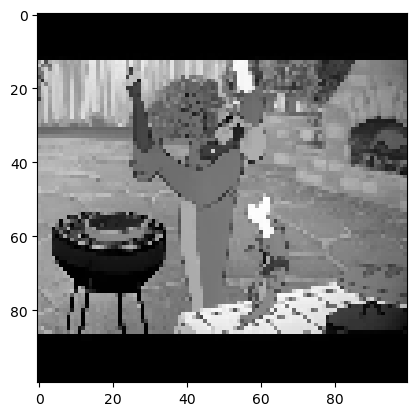

In [12]:
plt.imshow(images[4],cmap='gray')

In [15]:
images.shape

(5478, 100, 100)

In [16]:
#read in classifications
y_true = pd.read_csv('ground_truth.csv')
#y_true = y_true.sort_values(by='filename').reset_index(drop=True)

In [17]:
def class_creator(row):
    '''
    returns a class 0-3 for the 4 image classes
    -row: dataframe row to be worked with
    '''
    #only tom is in the frame = class 0
    if (row['tom'] == 1) & (row['jerry'] == 0):
        val = 0
    #only jerry is in the frame = class 1
    elif (row['tom'] == 0) & (row['jerry'] == 1):
        val = 1
    #neither tom nor jerry is in the frame = class 2
    elif (row['tom'] == 0) & (row['jerry'] == 0):
        val = 2
    #both tom and jerry are in the frame = class 3
    else:
        val = 3
    return val

In [18]:
#create a new column with these class values for each image
y_true['class'] = y_true.apply(class_creator, axis=1)

#drop all other columns and convert to an np array of the class values
y_true = y_true['class'].values

In [57]:
class Convolution2D:
    def __init__(self, k1, b1, stride=1, padding=0):
        """
          - k1: (6, 5, 5) kernels
          - b1: (6) bias
        """
        self.k1 = k1
        self.b1 = b1
        self.stride = stride
        self.padding = padding
        
    def relu(self,x):
        if x < 0:
            return 0
        else:
            return x

    def feedforward(self, img):
        """
          - img: (28, 28) image
        """

        N, k1_height, _ =  self.k1.shape

        C1_height = int((img.shape[0] - k1_height + 2 * self.padding) / self.stride) + 1

        # Initialize C
        C1 = np.zeros((N, C1_height, C1_height), dtype=np.float64)
        dC1S1 = np.zeros(C1.shape, dtype=np.float64)

        for n in range(N):
            for i in range(C1_height):
                for j in range(C1_height):
                    region = img[i:(i + k1_height), j:(j + k1_height)]
                    S1_nij = np.sum(region * self.k1[n]) + self.b1[n]
                    C1[n, i, j] = self.relu(S1_nij)
                    dC1S1[n, i, j] = 1 if S1_nij > 0 else 0

        return C1, dC1S1


class Convolution3D:
    def __init__(self, k2, b2, stride=1, padding=0):
        """
          - k2:   (12, 6, 5, 5) kernels
          - b2:   (12) bias
        """
        self.k2 = k2
        self.b2 = b2
        self.stride = stride
        self.padding = padding
        
    def relu(self,x):
        if x < 0:
            return 0
        else:
            return x

    def feedforward(self, P1):
        """
          - P1: (6, 12, 12) image
        """
        M, N, k2_height, _ = self.k2.shape
        C2_height = int((P1.shape[1] - k2_height + 2 * self.padding) / self.stride) + 1

        C2 = np.zeros((M, C2_height, C2_height), dtype=np.float64)
        dC2S2 = np.zeros(C2.shape, dtype=np.float64)
        dS2P1 = np.zeros(P1.shape + C2.shape, dtype=np.float64)

        for m in range(M):
            for u in range(C2_height):
                for v in range(C2_height):
                    region = P1[0:N, u:(u + k2_height), v:(v + k2_height)]
                    S2_muv = np.sum(region * self.k2[m]) + self.b2[m]
                    C2[m, u, v] = self.relu(S2_muv)
                    dC2S2[m, u, v] = 1 if S2_muv > 0 else 0
                    dS2P1[0:N, u:(u + k2_height), v:(v + k2_height), m, u, v] = self.k2[m]

        return C2, dC2S2, dS2P1

In [59]:
class MaxPool:
    def __init__(self, size=2):
        self.size = 2

    def feedforward(self, C):
        N, C_height, _ = C.shape
        P_height = int(C_height / self.size)

        P = np.zeros((N, P_height, P_height), dtype=np.float64)
        indices = np.zeros((N, P_height, P_height), dtype=(np.int64, 2))

        for n in range(N):
            for i in range(P_height):
                for j in range(P_height):
                    region = C[n, (2 * i):(2 * i + 2), (2 * j):(2 * j + 2)]
                    P[n, i, j] = np.max(region)
                    local_indices = np.unravel_index(np.argmax(region), region.shape)
                    indices[n, i, j] = [2 * i + local_indices[0], 2 * j + local_indices[1]]

        return P, indices

In [77]:
class CNN:
    def __init__(self, N, M):
        u1 = 0.1
        u2 = 0.1
        u = 0.1
        self.k1 = np.random.uniform(low=-u1, high=u1, size=(N, 5, 5))
        self.b1 = np.random.uniform(low=-u1, high=u1, size=(N))
        self.k2 = np.random.uniform(low=-u2, high=u2, size=(M, N, 5, 5))
        self.b2 = np.random.uniform(low=-u2, high=u2, size=(M))
        self.w = np.random.uniform(low=-u, high=u, size=(4, M * 484))
        self.b = np.random.uniform(low=-u, high=u, size=(4))
        
        
    def softmax(self,x):
        return np.exp(x) / np.sum(np.exp(x))

    def loss(self,y_pred):
        return -np.log(y_pred)


    def feedforward(self, img):
        ## Convolution Layer C1
        conv1 = Convolution2D(self.k1, self.b1, stride=1, padding=0)
        C1, dC1S1 = conv1.feedforward(img)

        ## Pooling Layer P1
        maxpool = MaxPool(size=2)
        P1, I1 = maxpool.feedforward(C1)

        ## Convolution Layer C2
        conv2 = Convolution3D(self.k2, self.b2, stride=1, padding=0)
        C2, dC2S2, dS2P1 = conv2.feedforward(P1)

        ## Pooling Layer P2
        P2, I2 = maxpool.feedforward(C2)

        ## FC Layer
        f = P2.flatten()
        O = self.softmax(np.dot(self.w, f) + self.b)

        return O


    def train(self, train_images, train_labels, test_images, test_labels, epoch, lr):
        N = self.k1.shape[0]
        M = self.k2.shape[0]
        epochs = []
        avg_losses = []
        accuracies = []

        for ep in range(epoch):
            # Shuffle the training data
            permutation = np.random.permutation(len(train_images))
            train_images = train_images[permutation]
            train_labels = train_labels[permutation]
            for img, label in tqdm(zip(train_images, train_labels)):

                ############################################################
                # Feedforward phase                                        #
                ############################################################

                ## Convolution Layer C1
                conv1 = Convolution2D(self.k1, self.b1, stride=1, padding=0)
                C1, dC1S1 = conv1.feedforward(img)

                ## Pooling Layer P1
                maxpool = MaxPool(size=2)
                P1, I1 = maxpool.feedforward(C1)

                ## Convolution Layer C2
                conv2 = Convolution3D(self.k2, self.b2, stride=1, padding=0)
                C2, dC2S2, dS2P1 = conv2.feedforward(P1)

                ## Pooling Layer P2
                P2, I2 = maxpool.feedforward(C2)

                ## FC Layer
                f = P2.flatten()
                O = self.softmax(np.dot(self.w, f) + self.b)


                ############################################################
                # Backpropagation phase                                    #
                ############################################################

                ## 1. Calculate gradients of parameters in the FC layer
                dLS = np.copy(O)
                dLS[label] = O[label] - 1
                dLb = np.copy(dLS)

                dLw = np.zeros(O.shape + f.shape, dtype=np.float64)
                for i in range(O.shape[0]):
                    dLw[i, :] = O[i] * f
                    dLw[label, :] = (O[label] - 1) * f

                    dLf = np.zeros(f.shape, dtype=np.float64)
                for j in range(f.shape[0]):
                    dLf[j] = np.sum(dLS * self.w[:, j])

                dLP2 = dLf.reshape(P2.shape)



                ## 2. Calculate gradients of parameters in the C2 layer

                ### 2.1. Calculate dLC2
                dLC2 = np.zeros(C2.shape, dtype=np.float64)

                for m in range(P2.shape[0]):
                    for x in range(P2.shape[1]):
                        for y in range(P2.shape[2]):
                            umax, vmax = I2[m, x, y]
                            dLC2[m, umax, vmax] = dLP2[m, x, y]

                ### 2.2. Calculate dLS2
                dLS2 = dLC2 * dC2S2

                ### 2.3. Calculate dLb2 and dLk2
                dLb2 = np.zeros(self.k2.shape[0], dtype=np.float64)
                dLk2 = np.zeros(self.k2.shape, dtype=np.float64)
                for m in range(self.k2.shape[0]):
                    dLb2[m] = np.sum(dLS2[m])
                    for n in range(self.k2.shape[1]):
                        for p in range(self.k2.shape[2]):
                              for q in range(self.k2.shape[3]):
                                    dLk2[m, n, p, q] = np.sum(dLS2[m] * P1[n][p:(p + C2.shape[1]), q:(q + C2.shape[2])])



                ## 3. Calculate gradients of parameters in the C1 layer

                ### 3.1. Calculate dLP1
                dLP1 = np.zeros(P1.shape, dtype=np.float64)
                for n in range(P1.shape[0]):
                    for r in range(P1.shape[1]):
                        for s in range(P1.shape[2]):
                              dLP1[n, r, s] = np.sum(dLS2 * dS2P1[n, r, s])


                ### 3.2. Calculate dLC1
                dLC1 = np.zeros(C1.shape, dtype=np.float64)
                for n in range(P1.shape[0]):
                    for r in range(P1.shape[1]):
                        for s in range(P1.shape[2]):
                            imax, jmax = I1[n, r, s]
                            dLC1[n, imax, jmax] = dLP1[n, r, s]

                ### 3.3. Calculate dLS1
                dLS1 = dLC1 * dC1S1

                ### 3.4. Calculate dLb1 and dLk1
                dLb1 = np.zeros(self.k1.shape[0], dtype=np.float64)
                dLk1 = np.zeros(self.k1.shape, dtype=np.float64)
                for n in range(self.k1.shape[0]):
                    dLb1[n] = np.sum(dLS1[n])
                    for g in range(self.k1.shape[1]):
                        for h in range(self.k1.shape[2]):
                            dLk1[n, g, h] = np.sum(dLS1[n] * img[g:(g + C1.shape[1]), h:(h + C1.shape[2])])


                ## 4. Update parameters
                self.k1 = self.k1 - lr * dLk1
                self.b1 = self.b1 - lr * dLb1

                self.k2 = self.k2 - lr * dLk2
                self.b2 = self.b2 - lr * dLb2

                self.w  = self.w  - lr * dLw
                self.b  = self.b  - lr * dLb


            losses = []
            acc = 0
            for img, label in zip(test_images, test_labels):
                O = self.feedforward(img)
                losses.append(-np.log(O[label]))
                acc += 1 if np.argmax(O) == label else 0
            losses = np.array(losses)

            epochs.append(ep + 1)
            avg_losses.append(losses.mean())
            accuracy = 100 * acc / len(test_labels)
            accuracies.append(accuracy)
            print("Epoch: {}, validate_average_loss: {}, validate_accuracy: {:02.2f}%".format(ep + 1, losses.mean(), accuracy))

        return (epochs, avg_losses, accuracies)

In [81]:
import pickle

np.set_printoptions(edgeitems=100, linewidth=200000)

cnn = CNN(6, 12)

train_images = images[0:50]
train_labels = y_true[0:50]

test_images = images[501:600]
test_labels = y_true[501:600]

stats = cnn.train(train_images, train_labels, test_images, test_labels, 10, 0.005)
epochs = stats[0]
avg_losses = stats[1]
accuracies = stats[2]

with open("artifacts/model.bin", "wb") as f:
    pickle.dump(cnn, f)



50it [05:15,  6.31s/it]


Epoch: 1, validate_average_loss: 1.1815198381126484, validate_accuracy: 35.35%


50it [05:14,  6.29s/it]


Epoch: 2, validate_average_loss: 1.0800077903448233, validate_accuracy: 35.35%


50it [05:11,  6.22s/it]


Epoch: 3, validate_average_loss: 1.0501081910652474, validate_accuracy: 35.35%


50it [03:28,  4.17s/it]


Epoch: 4, validate_average_loss: 1.0754395013637732, validate_accuracy: 36.36%


50it [02:54,  3.49s/it]


Epoch: 5, validate_average_loss: 1.0209235564879349, validate_accuracy: 49.49%


50it [02:53,  3.47s/it]


Epoch: 6, validate_average_loss: 1.0820764902792188, validate_accuracy: 42.42%


50it [02:53,  3.48s/it]


Epoch: 7, validate_average_loss: 0.8964336502849052, validate_accuracy: 59.60%


50it [02:57,  3.55s/it]


Epoch: 8, validate_average_loss: 1.049068975695804, validate_accuracy: 42.42%


50it [03:05,  3.71s/it]


Epoch: 9, validate_average_loss: 0.8415583727820438, validate_accuracy: 67.68%


50it [02:59,  3.58s/it]


Epoch: 10, validate_average_loss: 0.6443187643543636, validate_accuracy: 68.69%


FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/model.bin'

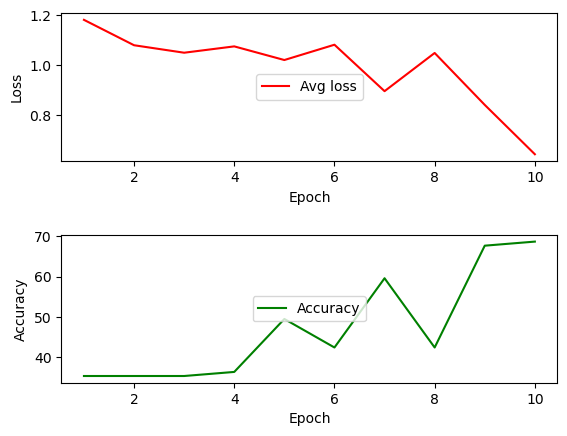

In [83]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.5)

g1 = fig.add_subplot(2, 1, 1, ylabel="Loss", xlabel="Epoch")
g1.plot(epochs, avg_losses, label="Avg loss", color="red")
g1.legend(loc="center")

g2 = fig.add_subplot(2, 1, 2, ylabel="Accuracy", xlabel="Epoch")
g2.plot(epochs, accuracies, label="Accuracy", color="green")
g2.legend(loc="center")

plt.show()